# Проект для оператора связи «ТелеДом» по снижению оттока клиентов

**Цель проекта** — помочь оператору связи «ТелеДом» снизить отток клиентов.

**План работы**

Данные будут получены из директорий `/datasets/contract_new.csv`, `/datasets/personal_new.csv`, `/datasets/internet_new.csv`, `/datasets/phone_new.csv`

О качестве данных ничего не известно. Поэтому перед построением модели, понадобится обзор данных.

Мы проверим данные на пропуски, дубликаты и по возможности избавимся от них. 

Затем, мы проведем исследовательский анализ данных - опишем полученные выводы по каждому столбцу.

Далее мы создадим модель и обучим ее.

После мы оценим результаты модели и сделаем выводы.

## Загрузка данных

In [1]:
# Скачиваем необходимые билиотеки
!pip install imblearn shap beautifulsoup4==4.9.3 matplotlib==3.5.0 -q nltk==3.6.1 numpy==1.20.1 pandas==1.2.4 plotly==5.4.0 psycopg2-binary==2.9.2 regex==2022.3.15 scikit-learn==1.6 scipy==1.8.0 seaborn==0.11.1 sqlalchemy==1.4.15 statsmodels==0.13.2 phik

In [2]:
# Подключаем нужные библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.svm import SVC, LinearSVC
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN
from sklearn.dummy import DummyClassifier
import shap

In [3]:
# Зададим константы
RANDOM_STATE = 190525
TEST_SIZE = 0.25

In [4]:
# Напишем функцию для считывания данных из csv файла и записывания в датафрейм
def df_read_csv(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Что-то пошло не так')

In [5]:
# Создадим функцию, для отображения нужной информации о датафрейме
def df_info(df):
    display(df.head(10))
    df.info()
    display(df.describe())

In [6]:
# Укажем актуальную дату выгрузки датафрейма
df_load = '2020-02-01'

In [7]:
# Считываем данные из csv файла и записываем их в переменную df
df_contract = df_read_csv('/datasets/contract_new.csv', 'https://code.s3.yandex.net/datasets/contract_new.csv')
df_personal = df_read_csv('/datasets/personal_new.csv', 'https://code.s3.yandex.net/datasets/personal_new.csv')
df_internet = df_read_csv('/datasets/internet_new.csv', 'https://code.s3.yandex.net/datasets/internet_new.csv')
df_phone = df_read_csv('/datasets/phone_new.csv', 'https://code.s3.yandex.net/datasets/phone_new.csv')

In [8]:
# Отобразим информацию о df
df_info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [9]:
# Отобразим информацию о df
df_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [10]:
# Отобразим информацию о df
df_info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3992-YWPKO,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [11]:
# Отобразим информацию о df
df_info(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9967-ATRFS,No
freq,1,3390


После загрузки необходимых файлов, имеем 4 датафрейма и 20 уникальных столбцов с данными.

В датафрейме `df_contract` мы сохранили информацию о договоре.

В датафрейме `df_personal` мы сохранили персональные данные клиента.

В датафрейме `df_internet` мы сохранили информацию об интернет-услугах.

В датафрейме `df_phone` мы сохранили информацию об услугах телефонии.

**Описание данных:**

**df_contract**
1. customerID — идентификатор абонента;
2. BeginDate — дата начала действия договора;
3. EndDate — дата окончания действия договора;
4. Type — тип оплаты: раз в год-два или ежемесячно;
5. PaperlessBilling — электронный расчётный лист;
6. PaymentMethod — тип платежа;
7. MonthlyCharges — расходы за месяц;
8. TotalCharges — общие расходы абонента.

**df_personal**
1. customerID — идентификатор пользователя;
2. gender — пол;
3. SeniorCitizen — является ли абонент пенсионером;
4. Partner — есть ли у абонента супруг или супруга;
5. Dependents — есть ли у абонента дети.

**df_internet**
1. customerID — идентификатор пользователя;
2. InternetService — тип подключения;
3. OnlineSecurity — блокировка опасных сайтов;
4. OnlineBackup — облачное хранилище файлов для резервного копирования данных;
5. DeviceProtection — антивирус;
6. TechSupport — выделенная линия технической поддержки;
7. StreamingTV — стриминговое телевидение;
8. StreamingMovies — каталог фильмов.

**df_phone**
1. customerID — идентификатор пользователя;
2. MultipleLines — подключение телефона к нескольким линиям одновременно.

Необходимо будет заменить тип данных у столбца `MonthlyCharges` и `SeniorCitizen` для экономии памяти.

## Предварительная предобработка данных

### Замена названий столбцов

In [12]:
df_contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
df_personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
df_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df_phone.columns = ['customer_id', 'multiple_lines']

### Удаление пропусков

**Заполним пропуски в столбце `total_charges`**

In [13]:
# Оценим данные с пропусками
df_contract.loc[df_contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Как видно из таблицы выше, пропуски обнаружены у абонентов, действие договоров которых началось в день выгрузки датафрейма

Заполним эти пропуски значениями из столбца `monthly_charges`

In [14]:
# Заполним пропуски
df_contract.loc[df_contract['total_charges'] == ' ', 'total_charges'] = df_contract.loc[df_contract['total_charges'] == ' ', 'monthly_charges']

**Определим кол-во пропусков в оставшихся столбцах**

In [15]:
df_contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [16]:
df_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [17]:
df_internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [18]:
df_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

Пропуски не обнаружены

### Выставление корректных типов данных

In [19]:
df_contract['monthly_charges'] = df_contract['monthly_charges'].astype('float32')
df_contract['total_charges'] = df_contract['total_charges'].astype('float32')
df_personal['senior_citizen'] = df_personal['senior_citizen'].astype('int32')

### Обработка дубликатов

**Найдем явные дубликаты**

In [20]:
df_contract.duplicated().sum()

0

In [21]:
df_personal.duplicated().sum()

0

In [22]:
df_internet.duplicated().sum()

0

In [23]:
df_phone.duplicated().sum()

0

Явные дубликаты не найдены

**Найдем неявные дубликаты**

In [24]:
print('Число записей:', len(df_contract))
print('Из них уникальных id:', df_contract['customer_id'].nunique())

Число записей: 7043
Из них уникальных id: 7043


In [25]:
print('Число записей:', len(df_personal))
print('Из них уникальных id:', df_personal['customer_id'].nunique())

Число записей: 7043
Из них уникальных id: 7043


In [26]:
print('Число записей:', len(df_internet))
print('Из них уникальных id:', df_internet['customer_id'].nunique())

Число записей: 5517
Из них уникальных id: 5517


In [27]:
print('Число записей:', len(df_phone))
print('Из них уникальных id:', df_phone['customer_id'].nunique())

Число записей: 6361
Из них уникальных id: 6361


Неявные дубликаты не найдены

На этапе предобработки данных, нам удалось:
1. Проверить данные на наличие пропусков
2. Выставить корректные типы данных для экономии памяти
3. Проверить данные на наличие дубликатов

## Предварительный исследовательский анализ данных

In [28]:
# Создадим функцию для отображения количественных признаков
def quant_feat(df, col, title, xlabel, ylabel):
    # Отобразим данные в столбце col
    display(df[col].describe())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.histplot(df[col], bins=100).set(xlabel=xlabel, ylabel=ylabel);
    
    # Отобразим ящик с усами, построенный для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.boxplot(df[col]).set(ylabel=xlabel);

In [29]:
# Создадим функцию для отображения качественных признаков в форме столбчатой диаграммы
def qual_feat_count(df, col, title, xlabel, ylabel):
    # Отобразим данные в столбце col
    display(df[col].describe())
    
    # Отобразим столбчатую диаграмму, построенную для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.countplot(df[col]).set(xlabel=xlabel, ylabel=ylabel);

In [30]:
# Создадим функцию для отображения качественных признаков в форме пирога
def qual_feat_pie(df, col, title, label):
    # Отобразим данные в столбце col
    display(df[col].value_counts())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.title(title, loc='center', pad=125)
    plt.pie(df[col].value_counts(), labels=[*label], autopct='%1.1f%%', radius=2);

### Изучим и опишем данные из таблицы df_contract

**Изучим столбец `begin_date`**

In [31]:
df_contract['begin_date'].min()

'2013-10-01'

In [32]:
df_contract['begin_date'].max()

'2020-02-01'

**Изучим столбец `end_date`**

In [33]:
df_contract['end_date'].min()

'2014-06-01'

In [34]:
df_contract['end_date'].max()

'No'

**Изучим столбец `type`**

count               7043
unique                 3
top       Month-to-month
freq                3875
Name: type, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


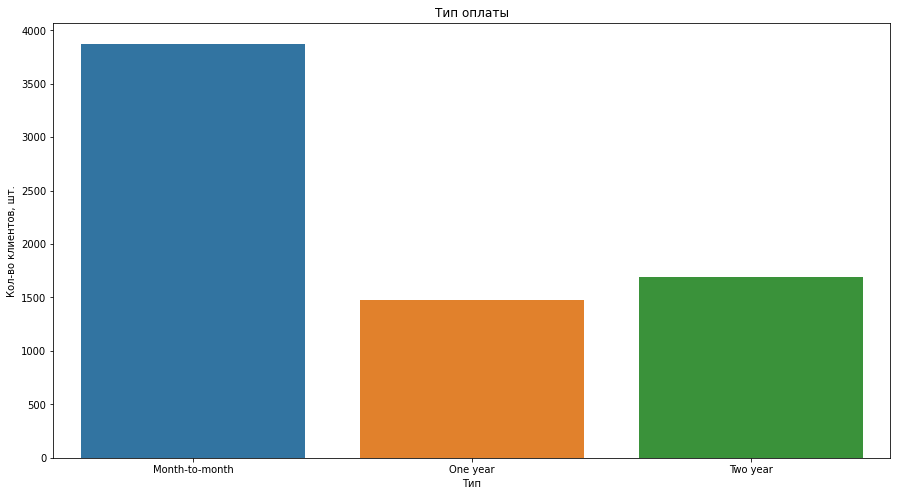

In [35]:
qual_feat_count(df_contract, 'type', 'Тип оплаты', 'Тип', 'Кол-во клиентов, шт.')

**Изучим столбец `paperless_billing`**

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

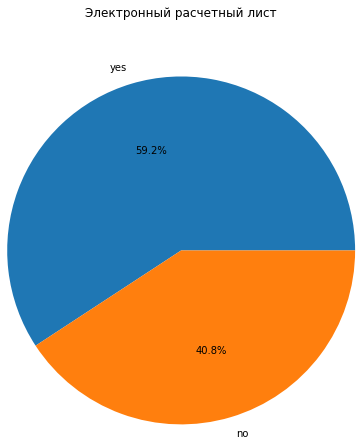

In [36]:
qual_feat_pie(df_contract, 'paperless_billing', 'Электронный расчетный лист', ['yes', 'no'])

**Изучим столбец `payment_method`**

count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: payment_method, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


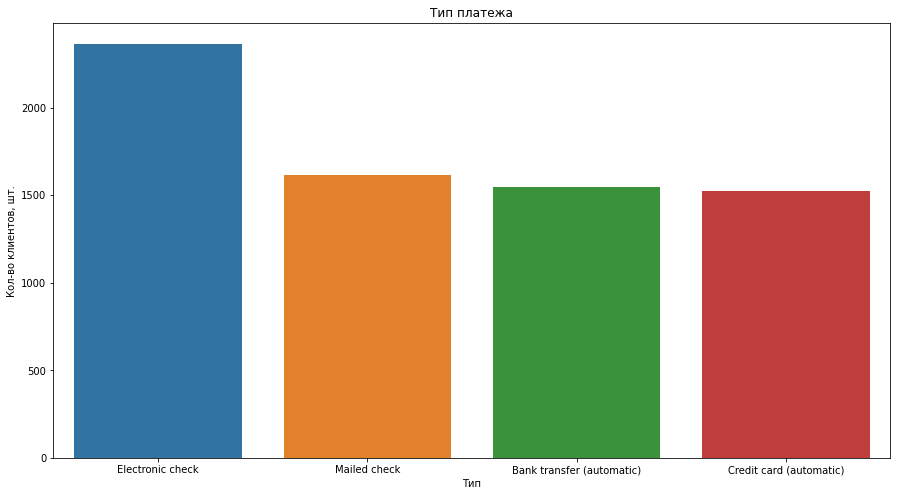

In [37]:
qual_feat_count(df_contract, 'payment_method', 'Тип платежа', 'Тип', 'Кол-во клиентов, шт.')

**Изучим столбец `monthly_charges`**

count    7043.000000
mean       64.761696
std        30.090048
min        18.250000
25%        35.500000
50%        70.349998
75%        89.849998
max       118.750000
Name: monthly_charges, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


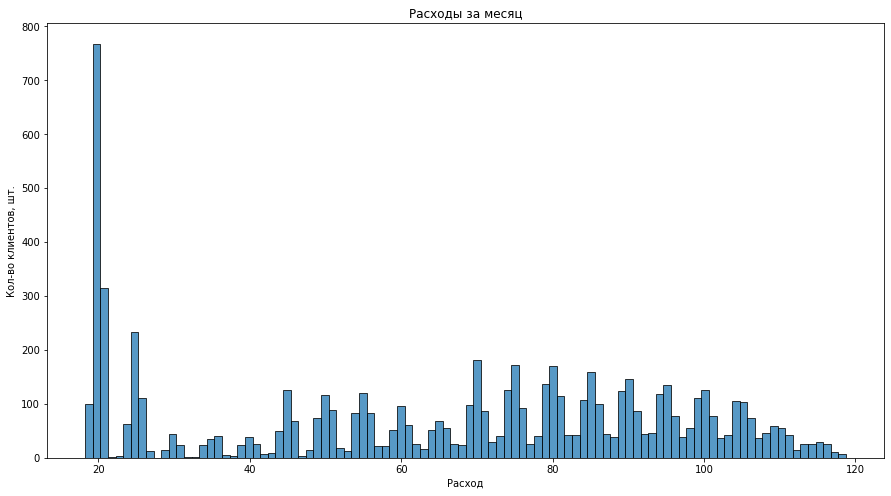

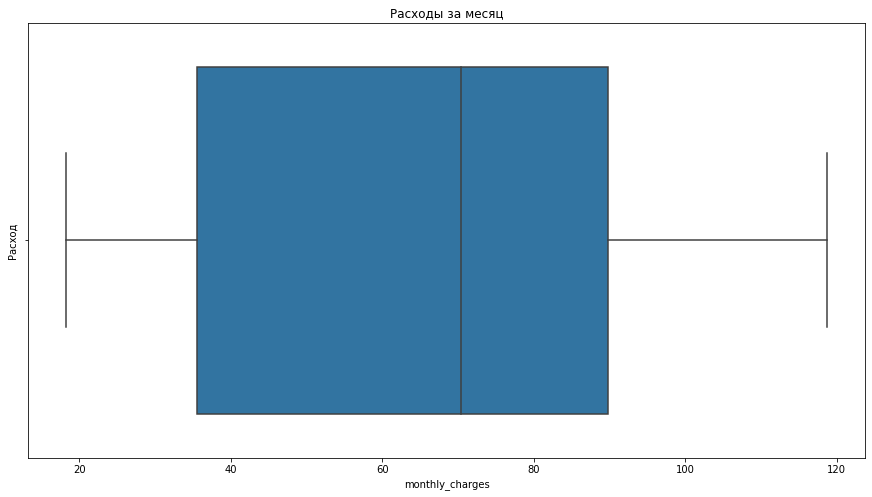

In [38]:
quant_feat(df_contract, 'monthly_charges', 'Расходы за месяц', 'Расход', 'Кол-во клиентов, шт.')

**Изучим столбец `total_charges`**

count    7043.000000
mean     2115.377441
std      2112.678955
min        19.049999
25%       436.750000
50%      1343.349976
75%      3236.689941
max      9221.379883
Name: total_charges, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


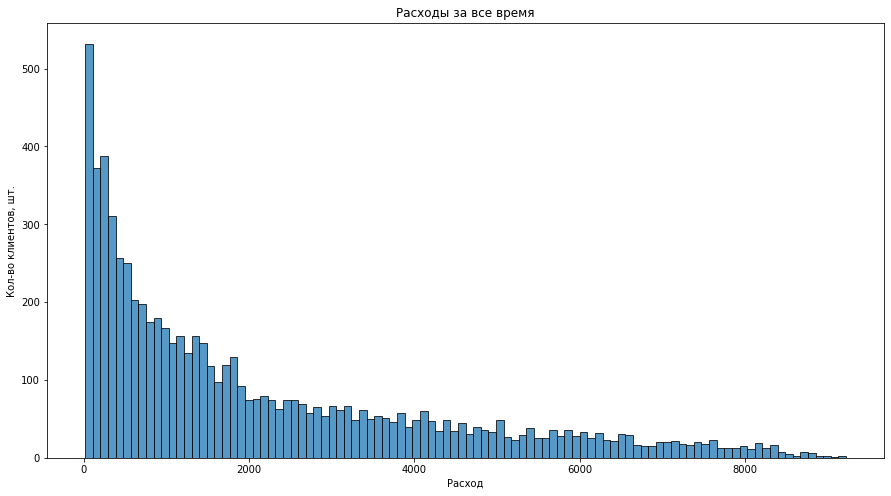

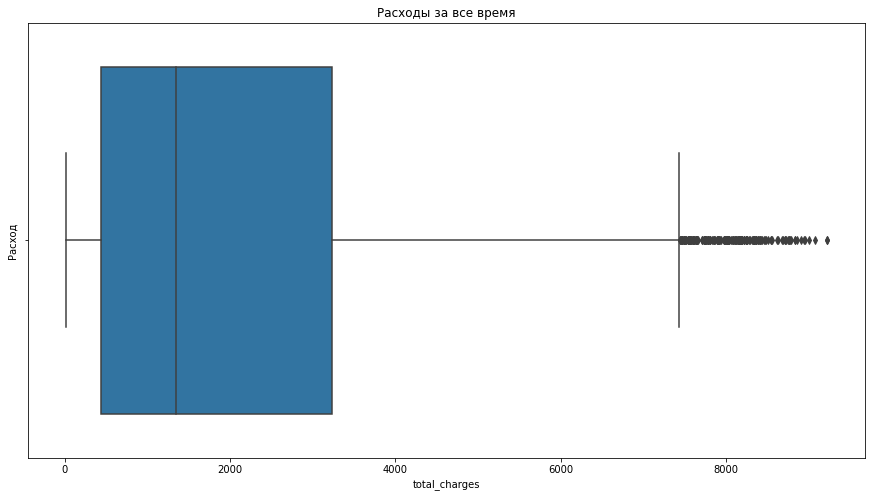

In [39]:
quant_feat(df_contract, 'total_charges', 'Расходы за все время', 'Расход', 'Кол-во клиентов, шт.')

### Изучим и опишем данные из таблицы df_personal

**Изучим столбец `gender`**

Male      3555
Female    3488
Name: gender, dtype: int64

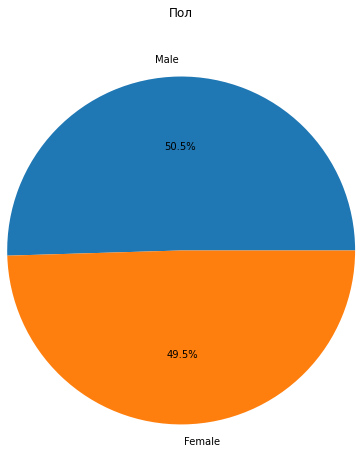

In [40]:
qual_feat_pie(df_personal, 'gender', 'Пол', ['Male', 'Female'])

**Изучим столбец `senior_citizen`**

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: senior_citizen, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


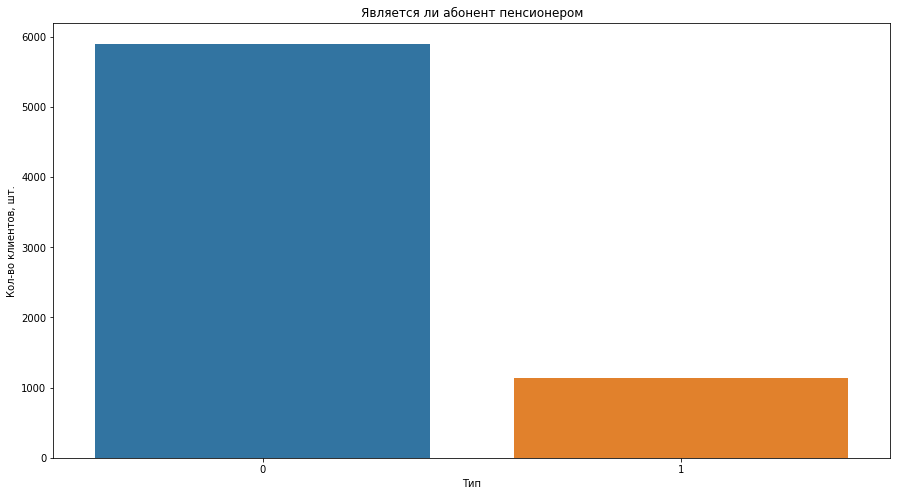

In [41]:
qual_feat_count(df_personal, 'senior_citizen', 'Является ли абонент пенсионером', 'Тип', 'Кол-во клиентов, шт.')

**Изучим столбец `partner`**

No     3641
Yes    3402
Name: partner, dtype: int64

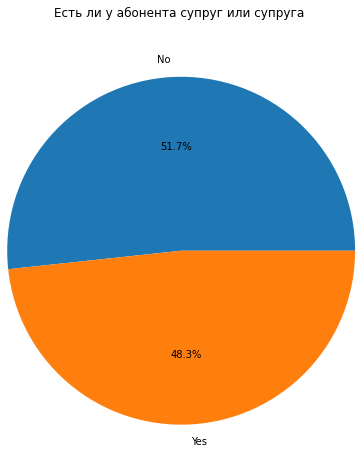

In [42]:
qual_feat_pie(df_personal, 'partner', 'Есть ли у абонента супруг или супруга ', ['No', 'Yes'])

**Изучим столбец `dependents`**

No     4933
Yes    2110
Name: dependents, dtype: int64

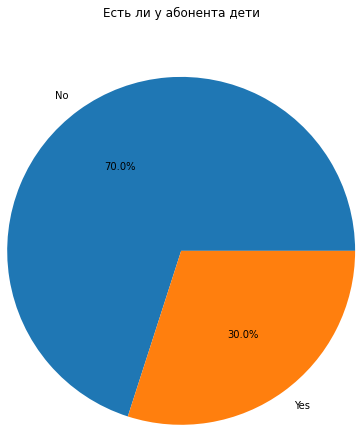

In [43]:
qual_feat_pie(df_personal, 'dependents', 'Есть ли у абонента дети', ['No', 'Yes'])

### Изучим и опишем данные из таблицы df_internet

**Изучим столбец `internet_service`**

count            5517
unique              2
top       Fiber optic
freq             3096
Name: internet_service, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


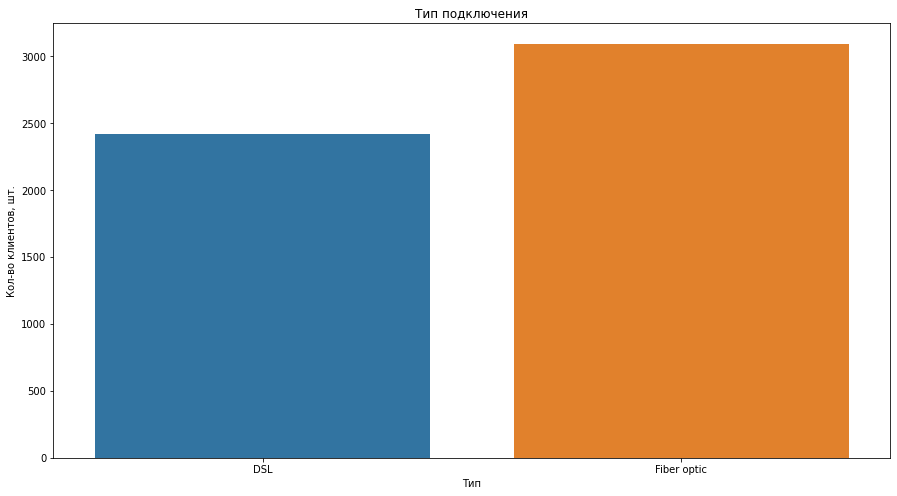

In [44]:
qual_feat_count(df_internet, 'internet_service', 'Тип подключения', 'Тип', 'Кол-во клиентов, шт.')

**Изучим столбец `online_security`**

No     3498
Yes    2019
Name: online_security, dtype: int64

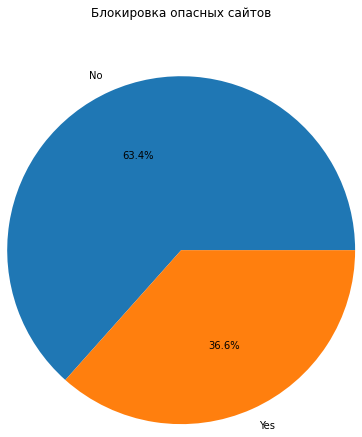

In [45]:
qual_feat_pie(df_internet, 'online_security', 'Блокировка опасных сайтов', ['No', 'Yes'])

**Изучим столбец `online_backup`**

No     3088
Yes    2429
Name: online_backup, dtype: int64

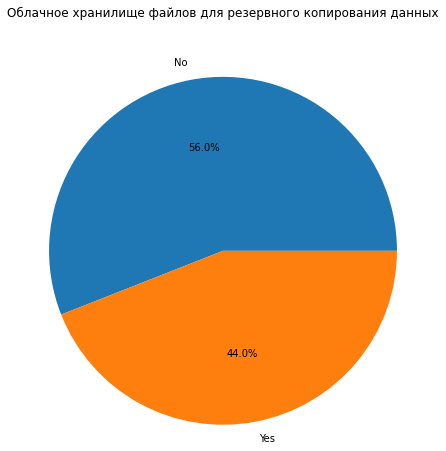

In [46]:
qual_feat_pie(df_internet, 'online_backup', 'Облачное хранилище файлов для резервного копирования данных', ['No', 'Yes'])

**Изучим столбец `device_protection`**

No     3095
Yes    2422
Name: device_protection, dtype: int64

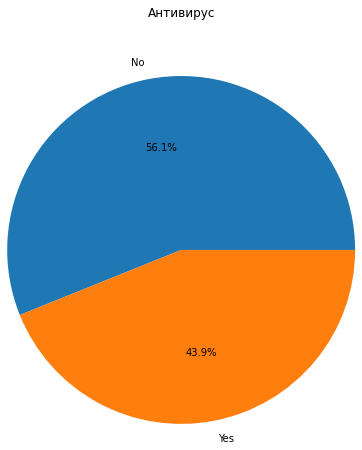

In [47]:
qual_feat_pie(df_internet, 'device_protection', 'Антивирус', ['No', 'Yes'])

**Изучим столбец `tech_support`**

No     3473
Yes    2044
Name: tech_support, dtype: int64

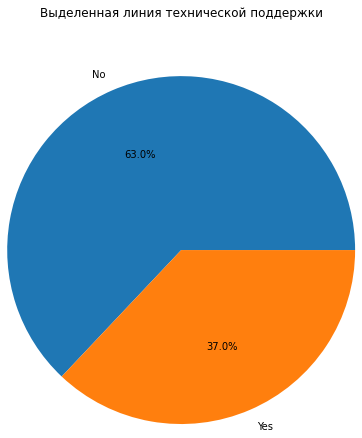

In [48]:
qual_feat_pie(df_internet, 'tech_support', 'Выделенная линия технической поддержки', ['No', 'Yes'])

**Изучим столбец `streaming_tv`**

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

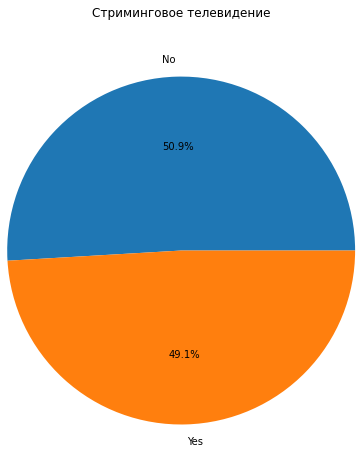

In [49]:
qual_feat_pie(df_internet, 'streaming_tv', 'Стриминговое телевидение', ['No', 'Yes'])

**Изучим столбец `streaming_movies`**

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

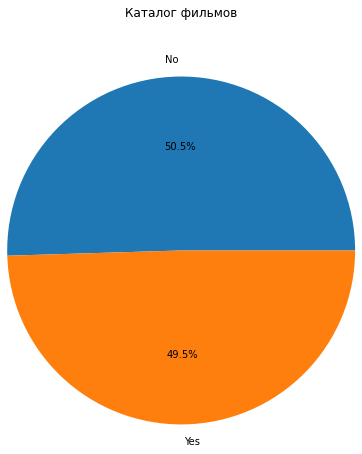

In [50]:
qual_feat_pie(df_internet, 'streaming_movies', 'Каталог фильмов', ['No', 'Yes'])

### Изучим и опишем данные из таблицы df_phone

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

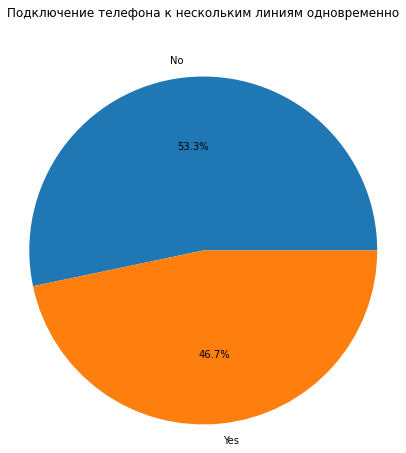

In [51]:
qual_feat_pie(df_phone, 'multiple_lines', 'Подключение телефона к нескольким линиям одновременно', ['No', 'Yes'])

На этапе предварительного исследовательского анализа данных, нам удалось:
1. Изучили и описали данные из таблиц df_contract, df_personal, df_internet, df_phone

По полученым данным, можно сказать:
1. Большинство абонентов (55%) предпочитают оплату раз в месяц
2. Наиболее популярным способом оплаты является электронный чек - им предпочитают расплачиваться 33% абонентов
3. Средний расход за месяц у абонентов - 65 у.е.
4. Средний расход за год у абонентов - 2 115 у.е.
5. 16% из всех абонентов составляют пенсионеры
6. У 70% абонентов нет детей
7. Наиболее популярными доп. услугами являются 'Блокировка опасных сайтов' и 'Выделенная линия технической поддержки' - они подключены у 63% абонентов

## Объединение данных

In [54]:
# Объединим таблицы
df_full = df_contract.merge(df_personal, on='customer_id', how='left')
df_full = df_full.merge(df_internet, on='customer_id', how='left')
df_full = df_full.merge(df_phone, on='customer_id', how='left')

In [55]:
# Отобразим информацию о df
df_info(df_full)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.650002,1150.959961,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.099998,2058.209961,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.750000,300.480011,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.800003,3573.679932,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.150002,1628.349976,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float32
 7   total_charges      7043 non-null   float32
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int32  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

,monthly_charges,total_charges,senior_citizen
count,7043.000000,7043.000000,7043.000000
mean,64.761696,2115.377441,0.162147
std,30.090048,2112.678955,0.368612
min,18.250000,19.049999,0.000000
25%,35.500000,436.750000,0.000000
50%,70.349998,1343.349976,0.000000
75%,89.849998,3236.689941,0.000000
max,118.750000,9221.379883,1.000000


## Предобработка данных

### Удаление пропусков

**Определим кол-во пропусков в оставшихся столбцах**

In [56]:
df_full.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Обнаружены пропуски, заполним их на этапе построения пайплайна

### Обработка дубликатов

**Найдем явные дубликаты**

In [57]:
df_full.duplicated().sum()

0

Явные дубликаты не найдены

**Найдем неявные дубликаты**

In [58]:
print('Число записей:', len(df_full))
print('Из них уникальных id:', df_full['customer_id'].nunique())

Число записей: 7043
Из них уникальных id: 7043


### Добавим дополнительные признаки

**Добавим целевой бинарный признак - ушел клиент или нет**

In [59]:
# Ушел - 1
# Остался - 0
df_full['client_left'] = df_full['end_date'].apply(lambda x: 0 if x == 'No' else 1)

**Добавим продолжительность действия договора с клиентом**

In [60]:
df_full['end_date_final'] = df_full['end_date'].apply(lambda x: df_load if x == 'No' else x)

In [61]:
df_full['begin_date'] = df_full['begin_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_full['end_date_final'] = df_full['end_date_final'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_full['duration_contract'] = df_full['end_date_final'] - df_full['begin_date']

In [62]:
df_full.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,end_date_final,duration_contract
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,...,No,Yes,No,No,No,No,NaN,0,2020-02-01,31 days
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,2071.840088,Male,0,...,Yes,No,Yes,No,No,No,No,0,2020-02-01,1036 days
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,...,Yes,Yes,No,No,No,No,No,0,2020-02-01,123 days
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,...,Yes,No,Yes,Yes,No,No,NaN,0,2020-02-01,1371 days
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,...,No,No,No,No,No,No,No,0,2020-02-01,153 days
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.650002,1150.959961,Female,0,...,No,No,Yes,No,Yes,Yes,Yes,0,2020-02-01,337 days
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.099998,2058.209961,Male,0,...,No,Yes,No,No,Yes,No,Yes,0,2020-02-01,671 days
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.750000,300.480011,Female,0,...,Yes,No,No,No,No,No,NaN,0,2020-02-01,306 days
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.800003,3573.679932,Female,0,...,No,No,Yes,Yes,Yes,Yes,Yes,0,2020-02-01,945 days
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.150002,1628.349976,Male,0,...,Yes,Yes,No,No,No,No,No,1,2017-05-01,882 days


На этапе предобработки данных, нам удалось:
1. Проверить данные на наличие пропусков
2. Выставить корректные типы данных для экономии памяти
3. Проверить данные на наличие дубликатов
4. Добавили дополнительные признаки

## Исследовательский анализ данных

### Сравним оставшихся и ушедших клиентов

In [64]:
# Переведем некоторые из категориальных строк с пропусками в тип str, для грамотного отображения на графике
cat_columns_nan = ['internet_service', 'online_security', 'online_backup', 'device_protection', 
                   'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
df_full[cat_columns_nan] = df_full[cat_columns_nan].astype('str')
df_full['duration_contract'] = df_full['duration_contract'].apply(lambda x: x.days)

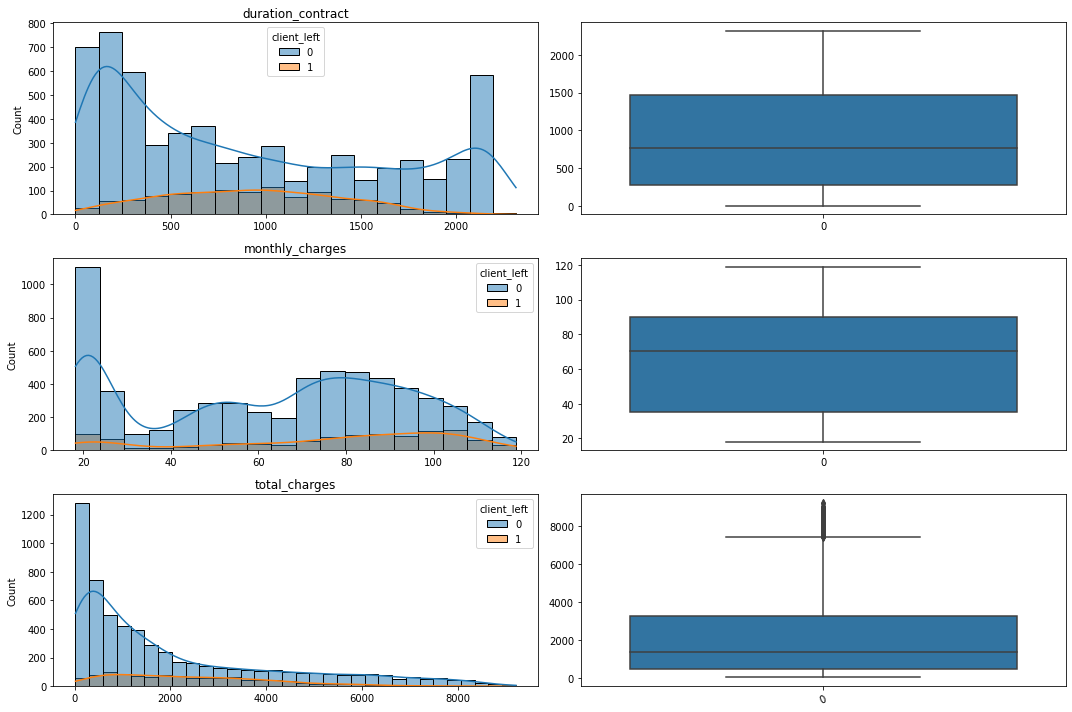

In [65]:
# Делаем новый холст в котором графики будут в 3 столбца, а число строк - количество признаков деленное на 3

features = ['duration_contract', 'monthly_charges', 'total_charges']

number_row = int(len(features)/3)
# добавим figsize=(15, 15) чтобы не было слишком мелкие графики
fig, ax = plt.subplots(nrows = number_row + 2, ncols=2, figsize=(15, 10))


# Вытягиваем
ax = ax.flatten()

j = 0
# Задаем цикл
for i in range(0, len(features), 1):
    sns.histplot(data = df_full, x = df_full[features[i]], hue='client_left', ax=ax[j], kde = True,)
    sns.boxplot(data = df_full[features[i]],  ax=ax[j+1])
    ax[j].set_title(f'{features[i]}')
    ax[j].set_xlabel('')
    plt.xticks(rotation = 25)
    j += 2



# Чтобы все надписи влезли    
fig.tight_layout()
fig.show()

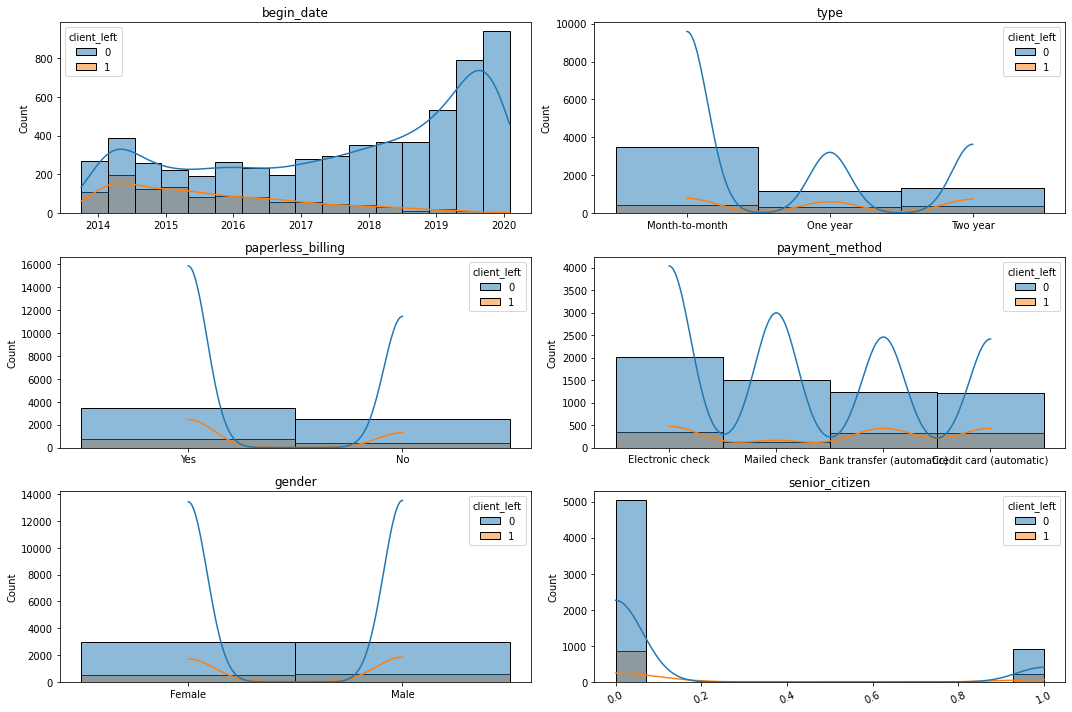

In [66]:
# Делаем новый холст в котором графики будут в 3 столбца, а число строк - количество признаков деленное на 3

features = ['begin_date', 'type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen']

number_row = int(len(features)/3)
# добавим figsize=(15, 15) чтобы не было слишком мелкие графики
fig, ax = plt.subplots(nrows = number_row + 1, ncols=2, figsize=(15, 10))


# Вытягиваем
ax = ax.flatten()

# Задаем цикл
for i in range(len(features)):
    sns.histplot(data = df_full, x = df_full[features[i]], hue='client_left', ax=ax[i], kde = True,)
    #sns.boxplot(data = df_full[features[i]],  ax=ax[i+1])
    ax[i].set_title(f'{features[i]}')
    ax[i].set_xlabel('')
    plt.xticks(rotation = 25)



# Чтобы все надписи влезли    
fig.tight_layout()
fig.show()

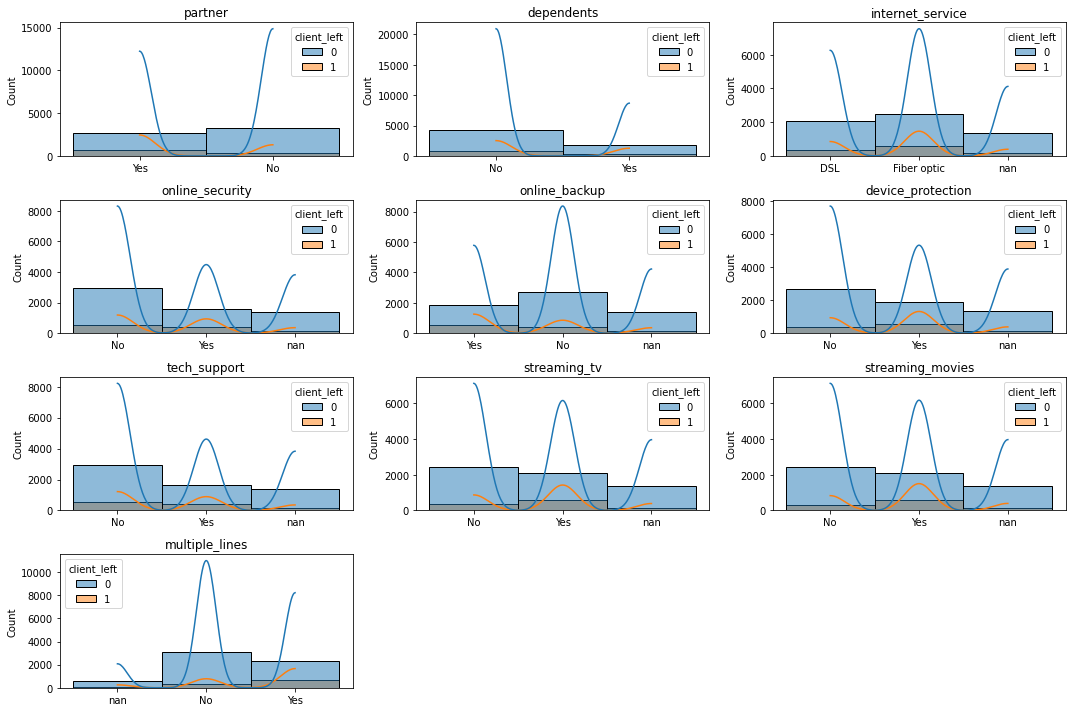

In [67]:
# Делаем новый холст в котором графики будут в 3 столбца, а число строк - количество признаков деленное на 3

features = ['partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

number_row = int(len(features)/3)
# добавим figsize=(15, 15) чтобы не было слишком мелкие графики
fig, ax = plt.subplots(nrows = number_row + 1, ncols=3, figsize=(15, 10))


# Вытягиваем
ax = ax.flatten()

# Задаем цикл
for i in range(len(features)):
    sns.histplot(data = df_full, x = df_full[features[i]], hue='client_left', ax=ax[i], kde = True,)
    ax[i].set_title(f'{features[i]}')
    ax[i].set_xlabel('')
    plt.xticks(rotation = 25)


# Удалим последний, ибо пустой  
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
#fig.delaxes(ax[-3])
            


# Чтобы все надписи влезли    
fig.tight_layout()
fig.show()

0    5942
1    1101
Name: client_left, dtype: int64

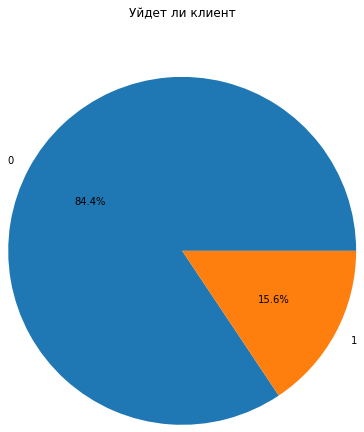

In [68]:
# Построим круговую диаграмму для стоблца client_left
qual_feat_pie(df_full, 'client_left', 'Уйдет ли клиент', ['0', '1'])

Как видно из диаграммы выше - в наборе данных есть дисбаланс классов. Устраним его на этапе построения пайплайна.

**Портрет ушедшего клиента:**
- В первые 1000 дней вероятность, что клиент уйдет растет с каждым днем, далее она начинает падать
- Наиболее популярные способы оплаты: электронный чек, банковский перевод, кредитная карта
- Чаще всего уходят клиенты с высокой месячной абонентской платой от 80 до 100 у.е.
- Чаще всего они не женаты / замужем
- Чаще всего пользуются услугой облачного хранилища
- Чаще всего пользуются услугой антивирус
- Чаще всего пользуются услугой потокового телевидения
- Чаще всего полузуются услугами каталог фильмов
- Чаще всего подключают телефон к нескольким линиям одновременно

На этапе исследовательского анализа данных, нам удалось:
1. Изучили и описали данные из таблицы df_full


2. Составили портрет «ушедшего клиента», его характерные черты: 
- В первые 1000 дней вероятность, что клиент уйдет растет с каждым днем, далее она начинает падать
- Наиболее популярные способы оплаты: электронный чек, банковский перевод, кредитная карта
- Чаще всего уходят клиенты с высокой месячной абонентской платой от 80 до 100 у.е.
- Чаще всего они не женаты / замужем
- Чаще всего пользуются услугой облачного хранилища
- Чаще всего пользуются услугой антивирус
- Чаще всего пользуются услугой потокового телевидения
- Чаще всего полузуются услугами каталог фильмов
- Чаще всего подключают телефон к нескольким линиям одновременно

##  Корреляционный анализ

**Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками**

In [69]:
# Преведем датафреймы к правильному типу данных
df_full[cat_columns_nan] = df_full[cat_columns_nan].astype('object')

for i in cat_columns_nan:
    df_full[i] = df_full[i].apply(lambda x: np.nan if x == 'nan' else x)

In [70]:
# Создадим новую таблицу на базе старой, без данных о дате
df_full_actual = df_full.copy()
df_full_actual = df_full_actual.drop(columns=['begin_date', 'end_date', 'end_date_final', 'customer_id'])

In [71]:
df_full_actual.head(10)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,duration_contract
0,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,31
1,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153
5,Month-to-month,Yes,Electronic check,99.650002,1150.959961,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
6,Month-to-month,Yes,Credit card (automatic),89.099998,2058.209961,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
7,Month-to-month,No,Mailed check,29.750000,300.480011,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN,0,306
8,Month-to-month,Yes,Electronic check,104.800003,3573.679932,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945
9,One year,No,Bank transfer (automatic),56.150002,1628.349976,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1,882


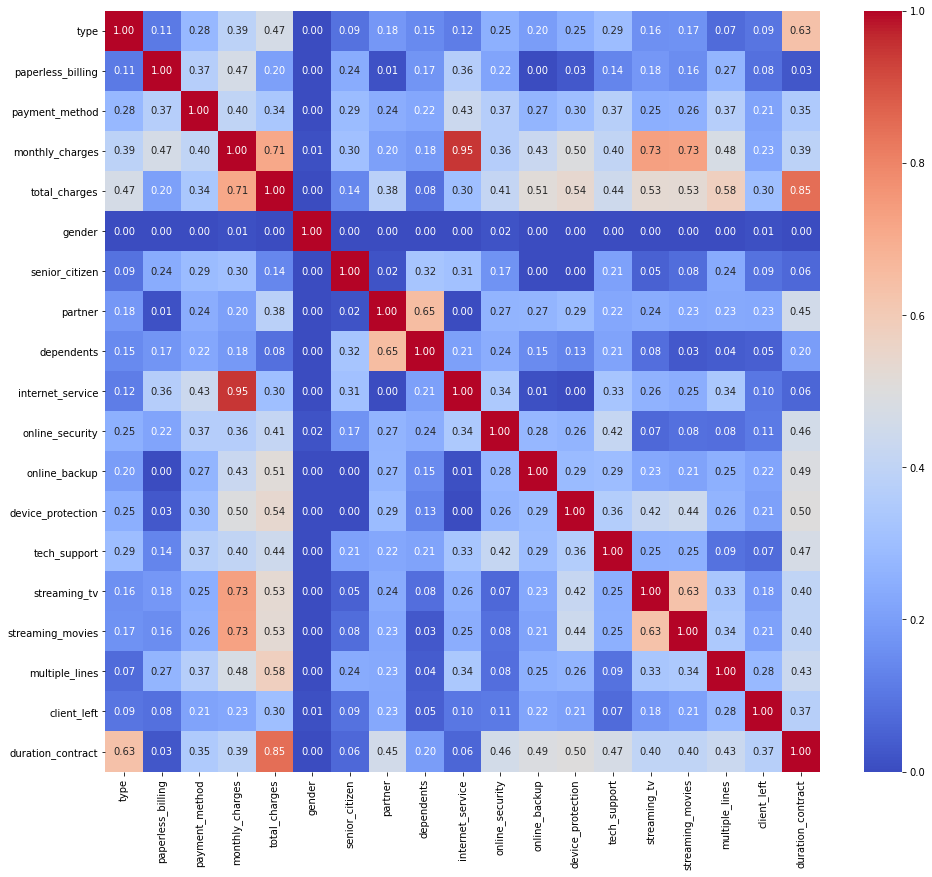

In [72]:
# Матрица корреляций для df_full_actual
plt.figure(figsize=(16, 14))
sns.heatmap(df_full_actual.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'senior_citizen', 'client_left', 'duration_contract']), annot=True,  cmap='coolwarm', fmt='.2f');

Судя по тепловой карте и опираясь на шкалу Чеддока мы можем сказать, что:
- Есть умеренная связь с целевым признаком `client_left` у входного признака `duration_contract` и `total_charges`
- Среди входных признаков `monthly_charges` и `internet_service` замечана мультиколлинеарность - коэффициент корреляции равен 0.95 по модулю

Проблему мультиколлинеарности устраним с помощью регуляризации на следующем этапе.

На этапе корреляционного анализа данных, нам удалось:
1. Рассчитать и изучить взаимосвязи между всеми признаками


2. Определить тип взаимосвязи между целевыми и входными признаками


3. Проверить входные данные на мультиколлинеарность

##  Обучение моделей

### Подготовим данные

In [73]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_full_actual.drop('client_left', axis=1),
    df_full_actual['client_left'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full_actual['client_left'])

In [74]:
# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5282, 18)
(5282,)
(1761, 18)
(1761,)


In [75]:
X_train.head(10)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_contract
6109,Month-to-month,No,Mailed check,54.150002,108.300003,Female,0,No,No,DSL,No,Yes,No,No,No,No,Yes,62
6075,One year,No,Mailed check,64.900002,649.000000,Female,0,No,No,DSL,No,Yes,No,Yes,No,Yes,No,306
4804,One year,Yes,Electronic check,118.599998,7234.600098,Female,0,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1857
1346,Month-to-month,Yes,Electronic check,87.250000,1047.000000,Female,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Yes,365
5217,Month-to-month,Yes,Mailed check,24.500000,245.000000,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,306
4837,Month-to-month,Yes,Electronic check,69.800003,287.579987,Female,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,No,123
4831,One year,Yes,Mailed check,40.200001,723.599976,Female,0,No,No,DSL,Yes,Yes,No,Yes,No,No,NaN,549
3239,Month-to-month,Yes,Mailed check,49.450001,791.200012,Male,0,No,No,DSL,No,No,No,Yes,No,No,No,488
5622,Month-to-month,Yes,Mailed check,104.050003,2705.300049,Male,0,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,792
5275,Month-to-month,No,Electronic check,53.750000,806.250000,Male,0,No,No,DSL,No,No,Yes,No,No,No,Yes,457


In [76]:
y_train.head(10)

6109    0
6075    0
4804    0
1346    1
5217    0
4837    0
4831    0
3239    0
5622    0
5275    0
Name: client_left, dtype: int64

### Создадим пайплайн

In [79]:
# Создаём списки с названиями признаков
ohe_columns = ['type' , 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 
              'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
num_columns = ['monthly_charges', 'total_charges', 'duration_contract']

In [80]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

In [81]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [82]:
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Обучим четыре модели

In [83]:
# В списке словарей укажем, какие модели и какие варианты масштабирования собираемся перебрать
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(loss_function='Logloss', iterations=40, random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [85]:
%%time
# Новый код
# Переберём разные модели и варианты масштабирования
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Learning rate set to 0.364815
0:	learn: 0.4769087	total: 56.9ms	remaining: 2.22s
1:	learn: 0.3869322	total: 59.3ms	remaining: 1.13s
2:	learn: 0.3631021	total: 61.5ms	remaining: 759ms
3:	learn: 0.3396870	total: 63.9ms	remaining: 575ms
4:	learn: 0.3273269	total: 66.2ms	remaining: 464ms
5:	learn: 0.3206135	total: 68.5ms	remaining: 388ms
6:	learn: 0.3151655	total: 70.8ms	remaining: 334ms
7:	learn: 0.3108718	total: 73.1ms	remaining: 293ms
8:	learn: 0.3065695	total: 75.4ms	remaining: 260ms
9:	learn: 0.3015142	total: 77.7ms	remaining: 233ms
10:	learn: 0.2964094	total: 80ms	remaining: 211ms
11:	learn: 0.2932970	total: 82.5ms	remaining: 192ms
12:	learn: 0.2875845	total: 84.8ms	remaining: 176ms
13:	learn: 0.2840605	total: 87.7ms	remaining: 163ms
14:	learn: 0.2797761	total: 90.7ms	remaining: 151ms
15:	learn: 0.2752337	total: 93.7ms	remaining: 140ms
16:	learn: 0.2721902	total: 96.6ms	remaining: 131ms
17:	learn: 0.2706889	total: 99.7ms	remaining: 122ms
18:	learn: 0.2688613	total: 103ms	remaining: 1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(fill_value='No',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'part...
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=190525,
                                                        solver='liblinear')],
                          'models__C': range(1, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

### Выберем лучшую модель

In [86]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
          

Для предсказания, мы:
- собрали пайплайн
- обучили и сделали прогноз по 4-ем моделям

Наилучший результат показала модель:
- CatBoostClassifier с параметрами iterations=40

## Анализ моделей

### Оценим модели

In [87]:
# Сохраним 10 лучших результатов в датафрейм и выведим на экран
all_results = pd.DataFrame(grid_search.cv_results_)
all_results = all_results.sort_values(by='rank_test_score')
all_results = all_results.reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
all_results[['param_models', 'rank_test_score', 'mean_test_score','params']]

,param_models,rank_test_score,mean_test_score,params
0,<catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>,1,0.844034,"{'models': <catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>, 'preprocessor__num': StandardScaler()}"
1,<catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>,2,0.844019,"{'models': <catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>, 'preprocessor__num': 'passthrough'}"
2,<catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>,3,0.844006,"{'models': <catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>, 'preprocessor__num': MinMaxScaler()}"
3,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",4,0.767610,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 5, 'models__max_features': 8, 'preprocessor__num': 'passthrough'}"
4,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",4,0.767610,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 5, 'models__max_features': 8, 'preprocessor__num': MinMaxScaler()}"
...,...,...,...,...
241,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",240,0.622179,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 3, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}"
242,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",243,0.608802,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}"
243,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",243,0.608802,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': MinMaxScaler()}"
244,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",243,0.608802,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': StandardScaler()}"


In [88]:
# Выберем лучшие варианты для 4-ех разных моделей
results = pd.DataFrame(grid_search.cv_results_)
results['model_name'] = results['param_models'].apply(lambda x: x.__class__.__name__)
top_per_model = results.groupby('model_name').apply(lambda x: x.nlargest(1, 'mean_test_score'))
top_per_model

,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_preprocessor__num,param_models__n_neighbors,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model_name
model_name,,,,,,,,,,,,,,,,,,,,,
CatBoostClassifier,243,0.819537,0.095866,0.023264,0.002656,<catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>,NaN,NaN,StandardScaler(),NaN,NaN,"{'models': <catboost.core.CatBoostClassifier object at 0x7f3f28df40d0>, 'preprocessor__num': StandardScaler()}",0.830354,0.850919,0.860252,0.848335,0.830310,0.844034,0.011870,1,CatBoostClassifier
DecisionTreeClassifier,91,0.050572,0.006169,0.016287,0.001619,"DecisionTreeClassifier(class_weight='balanced', random_state=190525)",5.0,8.0,MinMaxScaler(),NaN,NaN,"{'models': DecisionTreeClassifier(class_weight='balanced', random_state=190525), 'models__max_depth': 5, 'models__max_features': 8, 'preprocessor__num': MinMaxScaler()}",0.785508,0.771405,0.765357,0.774312,0.741465,0.767610,0.014617,4,DecisionTreeClassifier
KNeighborsClassifier,213,0.043916,0.002139,0.049774,0.003545,KNeighborsClassifier(),NaN,NaN,StandardScaler(),9.0,NaN,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 9, 'preprocessor__num': StandardScaler()}",0.762111,0.729088,0.785760,0.774111,0.731269,0.756468,0.022741,49,KNeighborsClassifier
LogisticRegression,230,0.257168,0.026222,0.032204,0.007726,"LogisticRegression(penalty='l1', random_state=190525, solver='liblinear')",NaN,NaN,passthrough,NaN,5.0,"{'models': LogisticRegression(penalty='l1', random_state=190525, solver='liblinear'), 'models__C': 5, 'preprocessor__num': 'passthrough'}",0.761829,0.765256,0.768003,0.765820,0.744455,0.761073,0.008542,22,LogisticRegression


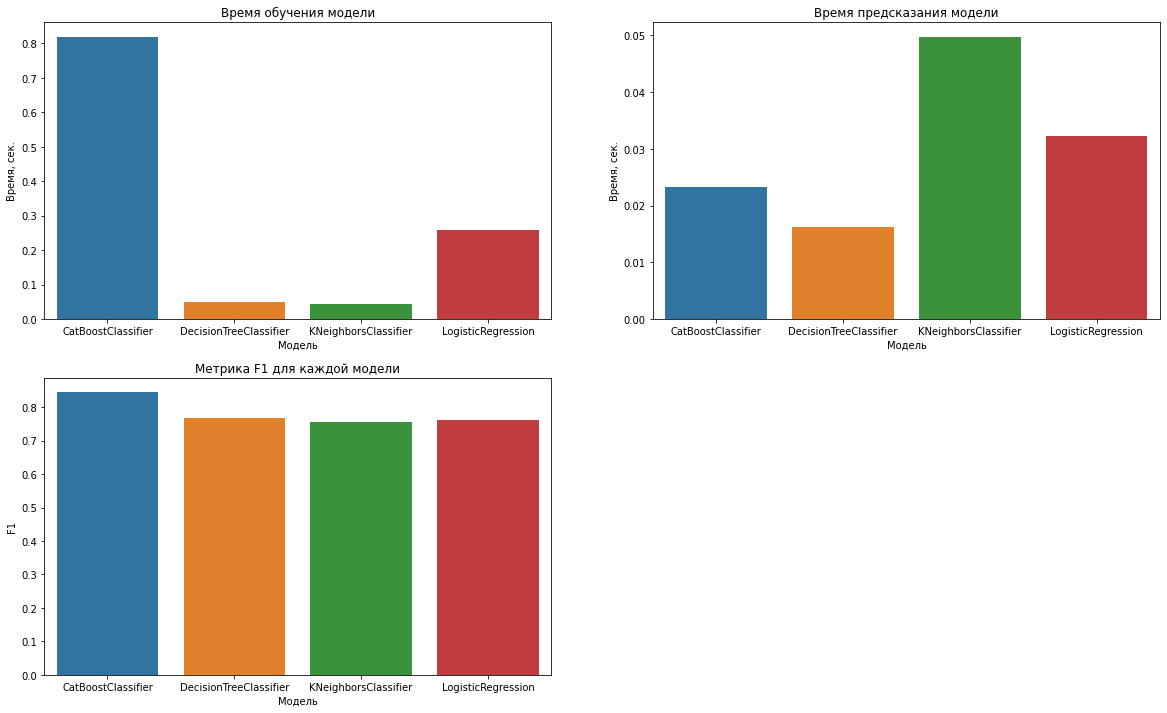

In [89]:
# Построим графики для 4-ех основных параметров для всех моделей и сравним их
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sns.barplot(data=top_per_model, x='model_name', y='mean_fit_time', ax=axes[0][0]).set(title='Время обучения модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_score_time', ax=axes[0][1]).set(title='Время предсказания модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_test_score', ax=axes[1][0]).set(title='Метрика F1 для каждой модели', xlabel='Модель', ylabel='F1');
fig.delaxes(axes[1][1])

Рейтинг моделей:
1. CatBoostClassifier

- Время обучения - 0.93 сек
- Время предсказания - 0.02 сек
- ROC-AUC на кросс-валидации - 0.844


2. DecisionTreeClassifier

- Время обучения - 0.04 сек
- Время предсказания - 0.01 сек
- ROC-AUC на кросс-валидации - 0.767

3. LogisticRegression

- Время обучения - 1.06 сек
- Время предсказания - 0.01 сек
- ROC-AUC на кросс-валидации - 0.761

4. KNeighborsClassifier

- Время обучения - 0.02 сек
- Время предсказания - 0.01 сек
- ROC-AUC на кросс-валидации - 0.756

Как видно из полученных результатов выше, самой оптимальной моделью с точи зрения времени и точности прогноза является модель CatBoostClassifier.

Применим ее на тестовых данных.

### Проверим лучшую модель на тестовой выборке

In [91]:
y_test = pd.DataFrame(y_test)
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_test_pred_one = best_model.predict_proba(X_test)[:, 1] 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_one)}')

Learning rate set to 0.40131
0:	learn: 0.4732618	total: 3.23ms	remaining: 126ms
1:	learn: 0.3804238	total: 5.93ms	remaining: 113ms
2:	learn: 0.3451283	total: 8.42ms	remaining: 104ms
3:	learn: 0.3327676	total: 10.9ms	remaining: 98.4ms
4:	learn: 0.3246954	total: 13.5ms	remaining: 94.5ms
5:	learn: 0.3208972	total: 16ms	remaining: 90.9ms
6:	learn: 0.3151835	total: 18.5ms	remaining: 87.3ms
7:	learn: 0.3116780	total: 21.1ms	remaining: 84.2ms
8:	learn: 0.3074273	total: 23.6ms	remaining: 81.5ms
9:	learn: 0.3046220	total: 28ms	remaining: 84ms
10:	learn: 0.3041381	total: 29.8ms	remaining: 78.5ms
11:	learn: 0.3003076	total: 33.1ms	remaining: 77.2ms
12:	learn: 0.2977240	total: 36.4ms	remaining: 75.6ms
13:	learn: 0.2945939	total: 39.9ms	remaining: 74.1ms
14:	learn: 0.2901400	total: 43.3ms	remaining: 72.1ms
15:	learn: 0.2859243	total: 47.5ms	remaining: 71.2ms
16:	learn: 0.2829296	total: 50.8ms	remaining: 68.7ms
17:	learn: 0.2810950	total: 54.2ms	remaining: 66.2ms
18:	learn: 0.2788139	total: 57.7ms	r

### Сравним результаты лучшей модели с прогнозированием DummyClassifier

In [92]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке при использовании DummyClassifier: {roc_auc_score(y_test, y_dummy)}')

Метрика ROC-AUC на тестовой выборке при использовании DummyClassifier: 0.5


Как видно из полученных результатов выше, модель CatBoostClassifier предсказывает значения лучше, чем DummyClassifier.

### Построим матрицу ошибок

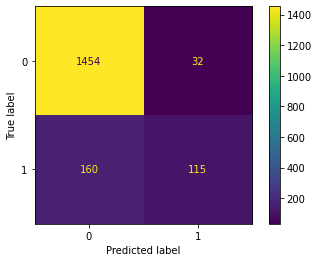

In [93]:
# Построим матрицу
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [94]:
# Оценим точность и полноту
recall = recall_score(y_test, best_model.predict(X_test))
precision = precision_score(y_test, best_model.predict(X_test))
print('Метрика recall на тестовой выборке:',round(recall ,3))
print('Метрика precision на тестовой выборке:',round(precision,3))

Метрика recall на тестовой выборке: 0.418
Метрика precision на тестовой выборке: 0.782


Как видно из матрицы выше:
1. Модель совершает 32 ошибки False Positive и 160 ошибок False Negative
2. Значение метрики recall - 0.418
3. Значение метрики precision - 0.782

##  Анализ важности признаков

### Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP

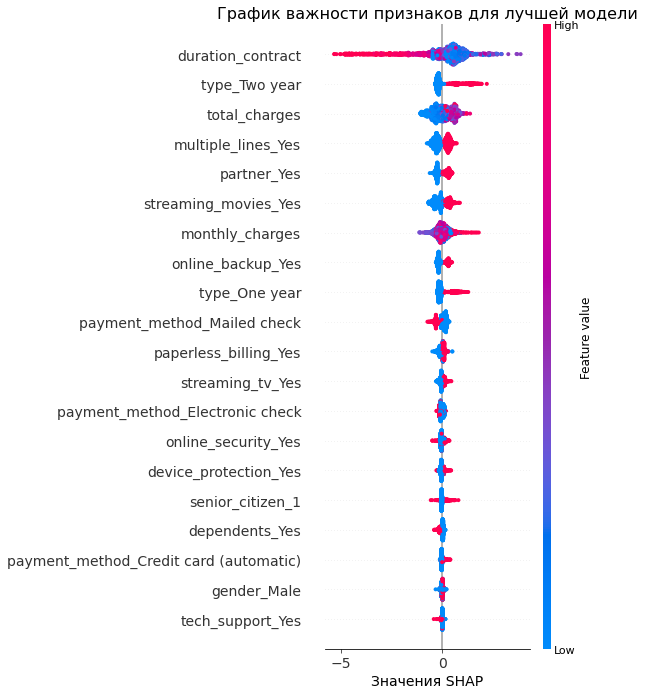

In [95]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
model = grid_search.best_estimator_.named_steps['models']

X_test_transformed = preprocessor.transform(X_test)

ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out()
num_features_names = num_columns

feature_names = list(ohe_feature_names) + list(num_features_names) 

X = pd.DataFrame(X_test_transformed, columns=feature_names)
 
explainer = shap.Explainer(model, X)

shap_values = explainer(X)
shap.summary_plot(shap_values[:, :], X_test_transformed, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("Значения SHAP", fontsize=14)
ax.set_title('График важности признаков для лучшей модели', fontsize=16)

plt.show()

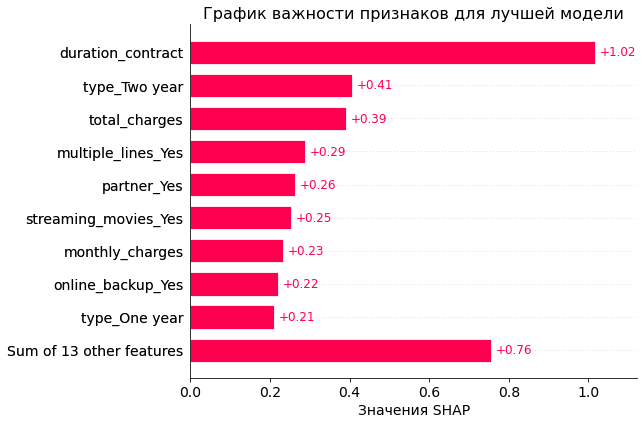

In [96]:
shap.plots.bar(shap_values[:, :], show=False)
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("Значения SHAP", fontsize=14)
ax.set_title('График важности признаков для лучшей модели', fontsize=16)
plt.show()

На этапе анализа важности признаков нам удалось:
1. Выявить топ-5 важных признаков
- длительность контракта
- тип оплаты
- суммарный расход за все время
- подключен ли телефон к нескольким линиям одновременно
- есть ли у абонента супруг или супруга

2. Выявить связь между важными признаками и предсказываемым значением
- чем выше длительность действующего контракта, тем ниже вероятность, что абонент уйдет
- чем дольше срок оплаты (раз в два года, раз в год), тем выше вероятность, что абонент уйдет
- чем выше суммарный расход за все время, тем выше вероятность, что абонент уйдет
- если телефон абонента подключен к нескольким линиям одновременно, то вероятность его ухода выше
- если абонент женат/замужем, вероятность его ухода выше

##  Минимизация убытков модели

In [97]:
# Всем абонентам, которые планируют уйти, мы будем вручать разовой промокод на скидку в 30% на месячную оплату
PROMO = 0.3

In [98]:
final_test = pd.DataFrame()
final_test['monthly_charges'] = X_test['monthly_charges']
final_test['pred_cat_proba'] = best_model.predict_proba(X_test)[:, 1]
final_test['target'] = y_test

In [99]:
final_test

,monthly_charges,pred_cat_proba,target
2691,59.099998,0.199264,0
4222,112.199997,0.038054,0
3317,70.800003,0.012078,0
6317,79.150002,0.063109,0
1574,19.650000,0.023824,0
...,...,...,...
5264,29.799999,0.167388,1
6355,110.250000,0.004533,0
1579,80.449997,0.033342,0
4473,98.099998,0.525450,0


In [100]:
# Функция для подсчета потерь
def cost(y_pred, y_target, charges):
    
    # Убытки от выданных промокодов лояльным клиентам
    if (y_pred != y_target) & (y_pred == 1):
        return charges * PROMO
    
    # Убытки от потери клиентов, которым не выдали промокоды
    elif (y_pred != y_target) & (y_pred == 0):
        return charges

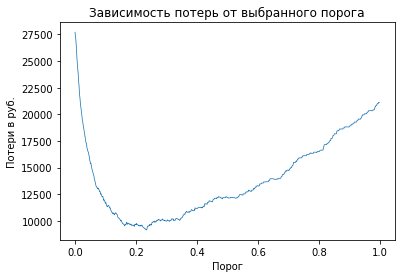

In [101]:
# Переберем все пороги от 0 до 1 с шагом в 0.001
thresholds = [round(i,3) for i in np.linspace(0, 1, num = 1000, endpoint=False)]

losses = []
columns = []

for i in thresholds:
    columns.append('threshold = '+str(i))
    final_test['pred_cat'] = final_test['pred_cat_proba'].apply(lambda x: 1 if x>= i else 0)
    final_test['losses'] = final_test.apply(lambda x : cost(x.pred_cat, x.target, x.monthly_charges), 1)
    losses.append(final_test['losses'].sum())

# Внесем данные о потерях при определенных порогах в таблицу    
costs = pd.DataFrame(zip(columns, losses),columns = ['Порог', 'Потери'])    

# Нарисуем график зависимости суммарных потерь от порога
heatmap = sns.lineplot(x=thresholds, y=[i for i in losses], size = 50, legend=False)
plt.ylabel('Потери в руб.')
plt.xlabel('Порог')
plt.title('Зависимость потерь от выбранного порога'); 

In [102]:
# Оценим таблицу с порогами
costs

,Порог,Потери
0,threshold = 0.0,27697.455025
1,threshold = 0.001,27398.115024
2,threshold = 0.002,27230.040023
3,threshold = 0.003,26888.025019
4,threshold = 0.004,26429.430019
...,...,...
995,threshold = 0.995,20998.050051
996,threshold = 0.996,21114.500048
997,threshold = 0.997,21114.500048
998,threshold = 0.998,21114.500048


In [103]:
# Выведем минимальное значение потерь
print(costs[costs['Потери'] == costs['Потери'].min()])

                 Порог       Потери
235  threshold = 0.235  9143.485016


Исходя из данных выше, мы можем сказать, что при пороге thresholds = 0.235 потери бизнеса будут минимальными

##  Общий вывод

**В процессе исследования, мы:**

**1. Выгрузили исходные данные в 4 датафрейма**

**2. Предобработали данные - выставили корректные типы данных, проверили данные на наличие пропусков**

**3. Провели исследовательский анализ данных**

Составили портрет «ушедшего клиента», его характерные черты: 
- В первые 1000 дней вероятность, что клиент уйдет растет с каждым днем, далее она начинает падать
- Наиболее популярные способы оплаты: электронный чек, банковский перевод, кредитная карта
- Чаще всего уходят клиенты с высокой месячной абонентской платой от 80 до 100 у.е.
- Чаще всего они не женаты / замужем
- Чаще всего пользуются услугой облачного хранилища
- Чаще всего пользуются услугой антивирус
- Чаще всего пользуются услугой потокового телевидения
- Чаще всего полузуются услугами каталог фильмов
- Чаще всего подключают телефон к нескольким линиям одновременно

**4. Собрали пайплайн, обучили и сделали прогноз для 5 моделей**

Наилучший результат показала модель:
- CatBoostClassifier с параметрами iterations=40

Рейтинг моделей:
1. CatBoostClassifier

- Время обучения - 0.93 сек
- Время предсказания - 0.02 сек
- ROC-AUC на кросс-валидации - 0.844


2. DecisionTreeClassifier

- Время обучения - 0.04 сек
- Время предсказания - 0.01 сек
- ROC-AUC на кросс-валидации - 0.767

3. LogisticRegression

- Время обучения - 1.06 сек
- Время предсказания - 0.01 сек
- ROC-AUC на кросс-валидации - 0.761

4. KNeighborsClassifier

- Время обучения - 0.02 сек
- Время предсказания - 0.01 сек
- ROC-AUC на кросс-валидации - 0.756

**5. Выбрали лучшую модель и проверили ее на тестовых данных**

- Метрика ROC-AUC на тестовой выборке при использовании лучшей модели: 0.88

Сравнили работу лучшей модели с моделью DummyClassifier:
- Метрика ROC-AUC на тестовой выборке при использовании DummyClassifier: 0.5

**6. Провели анализ важности признаков**

Топ-5 важных признаков:
- длительность контракта
- тип оплаты
- суммарный расход за все время
- подключен ли телефон к нескольким линиям одновременно
- есть ли у абонента супруг или супруга

Связь между важными признаками и предсказываемым значением
- чем выше длительность действующего контракта, тем ниже вероятность, что абонент уйдет
- чем дольше срок оплаты (раз в два года, раз в год), тем выше вероятность, что абонент уйдет
- чем выше суммарный расход за все время, тем выше вероятность, что абонент уйдет
- если телефон абонента подключен к нескольким линиям одновременно, то вероятность его ухода выше
- если абонент женат/замужем, вероятность его ухода выше

**7. Общие рекомендации для снижения оттока клиентов:**
1. Улучшить качество услуги подключения телефона к нескольким линиям одновременно
2. Предусмотреть семейные тарифы, например при подключении еще одного члена семьи выдается скидка на ежемесячную оплату
3. Предусмотреть скидки при оплате сразу за год или два